In [46]:
import json
import math

from utils import read_lines

In [47]:
PATH = json.load(open('../path_config.json'))

#### Read XSum

In [48]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [49]:
from tqdm import tqdm

In [50]:
data = json.load(open('../data/annotated_with_probability_200.json', 'r'))
print(len(data))

200


In [51]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_bos': 0.02984619140625,
   'bart.large.xsum': 0.0200347900390625,
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 1.9073486328125e-06,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.092529296875},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'xsum_cmlm_bos': 0.0843505859375,
   'bart.large.xsum': 0.06317138671875,
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 4.7087669372558594e-05,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.003948211669921875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent': 

#### Prior/Posterior Distribution Diagram

In [52]:
%matplotlib inline

from draw import plot_scatter

In [53]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

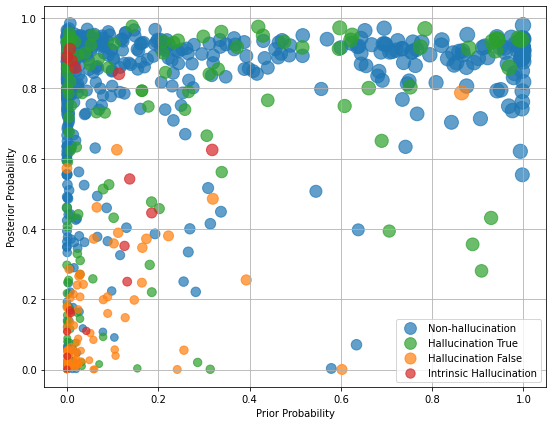

In [54]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data, labels)

#### Compare CMLM

In [55]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['text.usetex'] = False

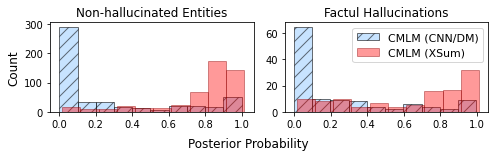

In [56]:
n_bins = 10
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.0))

my_blue = (153/255, 204/255, 1.0, 0.55)
my_edge = (0., 0., 0., 0.55)

priors_0 = [p['prior'] for p in prior_posterior if p['label'] == 0]
posteriors_0 = [p['posterior'] for p in prior_posterior if p['label'] == 0]
_, bins, _ = ax0.hist(priors_0, n_bins, density=False, histtype='bar', label='CMLM trained on CNN/DM',
                      facecolor=my_blue, edgecolor=my_edge, hatch='//')
ax0.hist(posteriors_0, bins=bins + 0.015, density=False, histtype='bar',
         facecolor='red', label='CMLM trained on XSum', edgecolor='darkred', alpha=0.40)
ax0.set_ylabel('Count', fontsize=12)
ax0.set_title('Non-hallucinated Entities', fontsize=12)

priors_1 = [p['prior'] for p in prior_posterior if p['label'] == 1]
posteriors_1 = [p['posterior'] for p in prior_posterior if p['label'] == 1]
_, bins, _ = ax1.hist(priors_1, n_bins, density=False, histtype='bar', 
                      facecolor=my_blue, label='CMLM (CNN/DM)', edgecolor=my_edge, hatch='//')
ax1.hist(posteriors_1, bins=bins + 0.015, density=False, histtype='bar',
         facecolor='red', label='CMLM (XSum)', edgecolor='darkred', alpha=0.40)
ax1.legend(prop={'size': 11})
ax1.set_title('Factul Hallucinations', fontsize=12)

fig.text(0.5, -0.05, 'Posterior Probability', ha='center', fontsize=12)
# fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()

plt.savefig("figures/" + 'hist_2cmlm' +'.pdf', bbox_inches="tight")
plt.show()

In [57]:
# selected_entities = []
# for e in prior_posterior:
#     if e['label'] == 1:
#         if e['prior'] > 1e-5 and math.log(e['posterior'] / e['prior']) > 5:
#             selected_entities.append(e)
#         if e['prior'] > 0. and math.log(e['posterior'] / e['prior']) < 0:
#             selected_entities.append(e)
#         elif e['posterior'] - e['prior'] > 0.5:
#             selected_entities.append(e)

In [58]:
# print(len(selected_entities))
# print(selected_entities[0])

In [59]:
# json.dump(selected_entities, open('sigma_entities.json', 'w'))

#### Get Average Entropy

In [60]:
import math

from draw import plot_hist

In [61]:
for l in range(3):
    posteriors = [p['prior'] for p in prior_posterior if p['label'] == l]
    print('- label {}: {}'.format(l, -math.log(sum(posteriors) / len(posteriors))))

- label 0: 1.404350662654027
- label 1: 1.4591605446529026
- label 2: 2.790782965517991


In [62]:
threshold = 0.0001
posteriors = [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['posterior'] > threshold:
            posteriors[l].append(p['posterior'])

In [63]:
threshold = 1e-7
priors= [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['prior'] > threshold:
            priors[l].append(p['prior'])

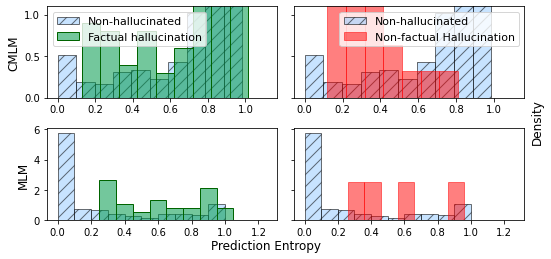

In [64]:
plot_hist('histogram', posteriors, priors, save_fig=True)

#### Evaluate Baseline Models

In [65]:
from sklearn.metrics import classification_report

In [66]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_bos': 0.019073486328125,
 'bart.large.xsum': 0.0927734375,
 'cnndm_cmlm_cedar': 0.80859375,
 'cnndm_cmlm_scratch_cedar_warmup_10000': 0.00147247314453125,
 'xsum_cmlm_scratch_cedar_warmup_20000': 0.01239013671875,
 'id': 8805,
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125}

In [67]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [68]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [69]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3517    0.9326    0.5108        89
     Factual     0.9873    0.7524    0.8540       618

    accuracy                         0.7751       707
   macro avg     0.6695    0.8425    0.6824       707
weighted avg     0.9073    0.7751    0.8108       707



In [70]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8390    0.9519    0.8919       208
    Hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [71]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1765    0.2022    0.1885        89
     Factual     0.8826    0.8641    0.8733       618

    accuracy                         0.7808       707
   macro avg     0.5296    0.5332    0.5309       707
weighted avg     0.7937    0.7808    0.7871       707



In [72]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.3529    0.1731    0.2323       208
    Hallucinated     0.7157    0.8677    0.7844       499

        accuracy                         0.6634       707
       macro avg     0.5343    0.5204    0.5083       707
    weighted avg     0.6090    0.6634    0.6220       707



### KNN Evaluation

In [73]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three, plot_three_with_boundary

In [74]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [75]:
n = 20
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=n)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6901    0.5673    0.6227       208
Non-hallucinated     0.8321    0.8938    0.8618       499

        accuracy                         0.7977       707
       macro avg     0.7611    0.7305    0.7423       707
    weighted avg     0.7903    0.7977    0.7915       707



In [76]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, factual_label, n_neighbors=20)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.5385    0.6292    0.5803        89
     Factual     0.9453    0.9223    0.9337       618

    accuracy                         0.8854       707
   macro avg     0.7419    0.7758    0.7570       707
weighted avg     0.8941    0.8854    0.8892       707



#### KNN with More Features

In [91]:
def leave_one_out_error_three_features(prior_probs, posterior_probs, overlaps, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels) == len(overlaps)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')
        
        x_mat = np.array(train_features)
#         x_mat = np.vstack([x_mat[:, 0] / np.std(x_mat[:, 0]), 
#                            x_mat[:, 1] / np.std(x_mat[:, 1]), 
#                            x_mat[:, 2] / np.std(x_mat[:, 2])]).transpose()
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [92]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, n_neighbors=20)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.8390    0.9519    0.8919       208
Non-hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [93]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, factual_label, n_neighbors=20)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.6154    0.6292    0.6222        89
     Factual     0.9464    0.9434    0.9449       618

    accuracy                         0.9038       707
   macro avg     0.7809    0.7863    0.7836       707
weighted avg     0.9048    0.9038    0.9043       707



#### KNN Classification Boundaries

In [77]:
font = {'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

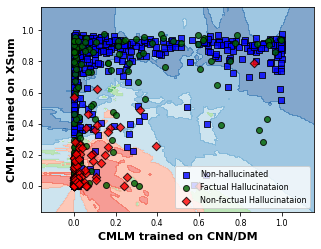

In [78]:
plot_three_with_boundary('entity_distribution_2cmlm',
                         posterior_probabilities, prior_probabilities, true_label,
                         colors=['blue', 'darkgreen', 'red'],
                         legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
                         x_label='CMLM trained on CNN/DM',
                         y_label='CMLM trained on XSum',
                         n_neighbors=16,
                         fig_size=(4.5, 3.5),
                         interval=0.25, h=0.05,
                         save_figure=True)

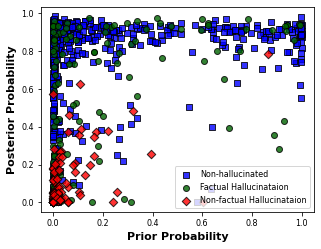

In [79]:
plot_three('entity_distribution_mlm_cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['blue','darkgreen', 'red'],
           x_label='Prior Probability',
           y_label='Posterior Probability',
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5),
           save_figure=True)

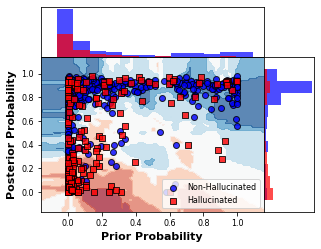

In [80]:
plot('Hallucination Entity Classification',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'])

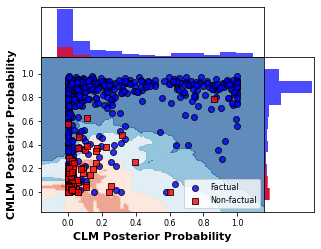

In [81]:
plot('compare_mlm_and_cmlm', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'],
     x_label='CLM Posterior Probability', y_label='CMLM Posterior Probability', save_figure=True)

In [82]:
down, up = 0, 0
for p in prior_posterior:
    if p['label'] == 1:
        if p['prior'] > p['posterior']:
            down += 1
        else:
            up += 1
print(down)
print(up)

18
101


#### Save KNN Model

In [83]:
import pickle

In [84]:
def build_KNN(posteriors, priors, labels, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [85]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, hallucination_label_reverse, n_neighbors=5)

In [86]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities]).transpose()))

In [87]:
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.7115    0.3558    0.4744       208
     Factual     0.7778    0.9399    0.8512       499

    accuracy                         0.7680       707
   macro avg     0.7447    0.6478    0.6628       707
weighted avg     0.7583    0.7680    0.7403       707



In [88]:
# source, destination
# pickle.dump(knn_classifier, open('classifiers/knn_mlm_cmlm_hallucination.pkl', 'wb'))

#### AUC

In [89]:
from draw import draw_auc

In [90]:
p1, p2, p3, p4, p5, p6, p7 = [], [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['bart.large'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_10000'])
        p4.append(p['cnndm_cmlm_cedar'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_10000'])
        p6.append(p['bart.large.xsum'])
        p7.append(p['bart.large.cnn'])

assert len(p1) == len(factual_label)

KeyError: 'xsum_cmlm_scratch_cedar_warmup_10000'

In [ ]:
draw_auc(factual_label,
         [p1, p2, p3, p4, p5, p6, p7],
         ['MLM', 'CMLM on XSum', 'CMLM on XSum scratch', 'CMLM on CNN/DM', 'CMLM on CNN/DM scratch', 'CLM on XSum', 'CLM on CNN/DM'],
         ['darkorange', 'green', 'red', 'blue', 'pink', 'aqua', 'tab:purple'])

In [ ]:
draw_auc(factual_label,
         [p2, p6, p4, p7],
         ['CMLM on XSum', 'CLM on XSum', 'CMLM on CNN/DM', 'CLM on CNN/DM'],
         ['darkorange', 'green', 'red', 'blue'])